In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Lab 4: Working with 'real' data

In [3]:
hf = h5py.File('gammaray_lab4.h5','r')

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0] #time (gps seconds), solar phase (deg), earth longitude (deg), gamma-ray count

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

### Problem 1:
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

##### 1) Explore your data by making a few plots and give a high level description of the data features you see. Do you see signal contamination in your data? How do you plan to build a background pdf()?

Data is a table with four columns: Time, Solar Phase, Longitude, and Gamma Ray Count.

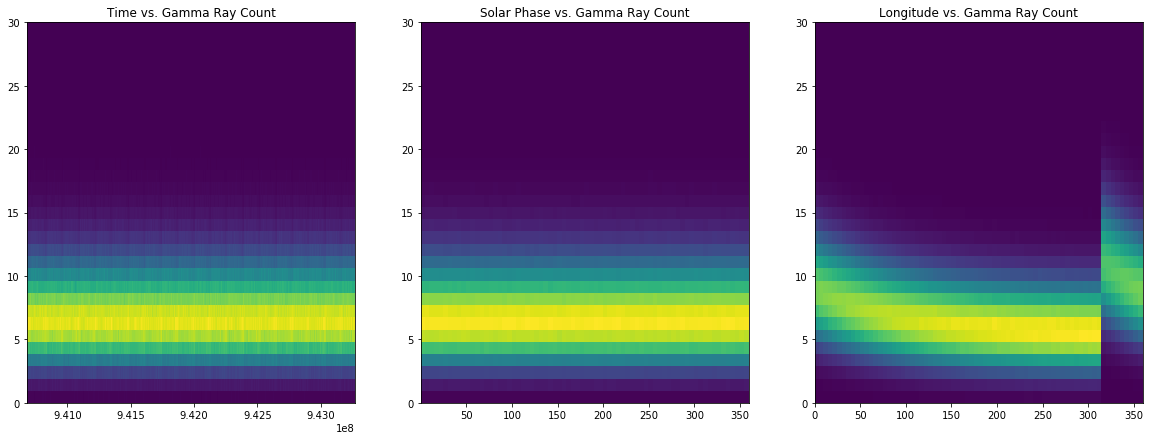

In [13]:
plt.rcParams["figure.figsize"] = (20,7)

fig, (plt1,plt2,plt3) = plt.subplots(1,3)
plt1.hist2d(data[0],data[3], bins = [500,31])
plt2.hist2d(data[1],data[3], bins = [72,31])
plt3.hist2d(data[2],data[3], bins = [72,31])

plt1.title.set_text('Time vs. Gamma Ray Count')
plt2.title.set_text('Solar Phase vs. Gamma Ray Count')
plt3.title.set_text('Longitude vs. Gamma Ray Count')

As we can see here, the number of gamma rays detected remains mostly consistent with respect to time and solar phase, but there is a noticeable deviation when longitude is between ~300 and 150 degrees. This tells us that the number of gamma ray detections is independent of time or solar phase, thus showing us our background distribution. We believe that there is some amount of signal contamination due to the discontinuity in the longitude plot at around 320 degrees.

In [26]:
raw = data[2][::100]
np.shape(raw)

(259201,)

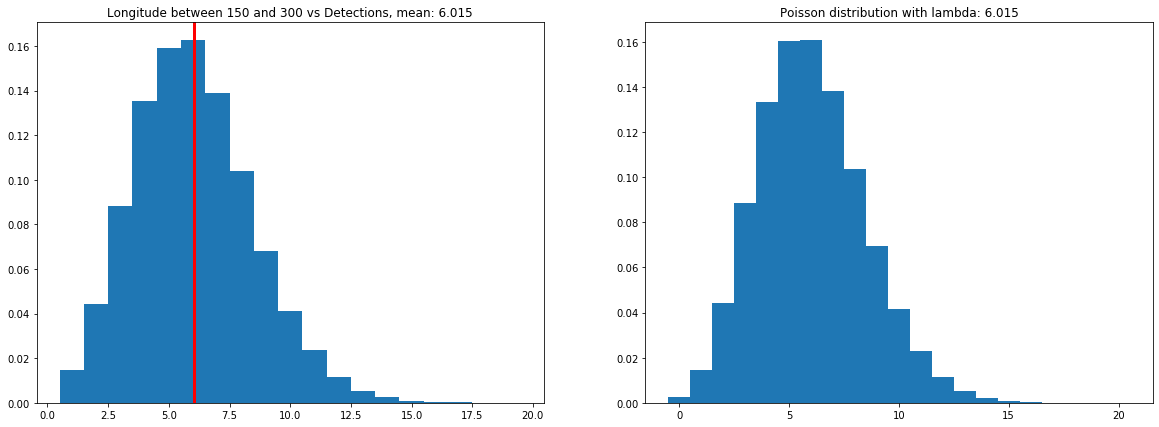

In [41]:
step = 100
raw = data[2][::step]
section = np.logical_and(raw>150, raw<300)

fig, (plt1,plt2) = plt.subplots(1,2)

plt1.hist(data[3][::step][section], bins = np.arange(0.5,20,1), density = True)
mean = np.mean(data[3][::step][section])
plt1.axvline(mean, linewidth = 3, color='red')
plt1.title.set_text('Longitude between 150 and 300 vs Detections, mean: '+str(np.round(mean,3)))

x = range(0,21)
plt2.bar(x, stats.poisson.pmf(x,mean),width=1)
plt2.title.set_text('Poisson distribution with lambda: '+str(np.round(mean,3)))


plt.show()


Here we examine the background distribution, and find that our background is a poisson distribution with lamba = 6.015.

##### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

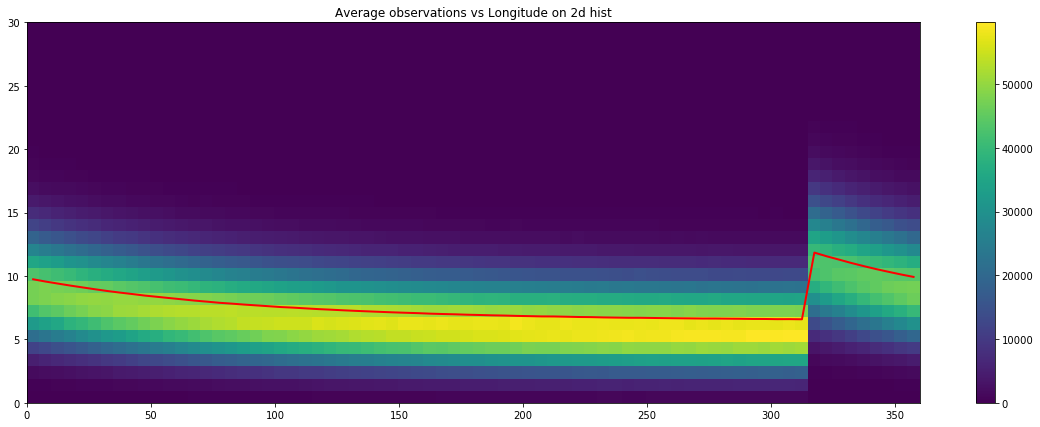

In [58]:
dist = plt.hist2d(data[2],data[3], bins=[72,31])
mean = np.zeros(72)
for i in range(0,72):
    mean[i] = sum(dist[2][1:]*dist[0][i,:]/sum(dist[0][i,:]))
plt.plot(dist[1][1:]-2.5, mean, linewidth=2, color = 'red')
plt.title('Average observations vs Longitude on 2d hist')
plt.colorbar()
plt.show()

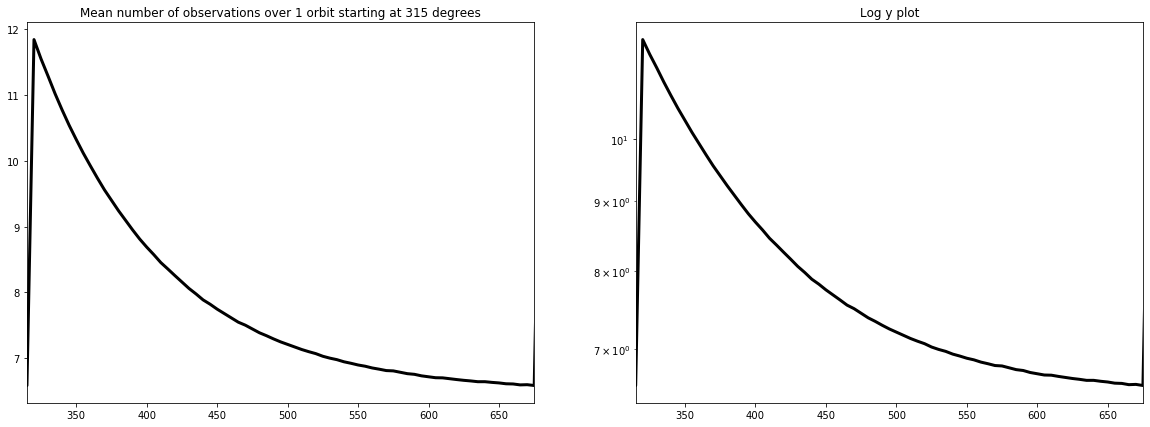

In [68]:
fig, (plt1,plt2) = plt.subplots(1,2)

plt1.plot(np.append(dist[1][1:], dist[1][1:]+360), np.append(mean,mean), linewidth = 3, color = 'black')
plt1.title.set_text('Mean number of observations over 1 orbit starting at 315 degrees')
plt1.set_xlim([315,675])

plt2.plot(np.append(dist[1][1:], dist[1][1:]+360), np.append(mean,mean), linewidth = 3, color = 'black')
plt2.title.set_text('Log y plot')
plt2.set_yscale('log')
plt2.set_xlim(315,675)
plt.show()

As we noted in 1-1, the signal seems to depend on the longitude of the observation device. Above, we plot the average number of observations detected by the satelite per degree in five degree increments. The mean appears to decay exponentially from just under 12 to the background value of 6.015. However, because the log(y) scale is non-linear, it seems there is no exponential relationship.